# IMPORTS


In [1]:
import pydicom as dicom
import numpy as np
import scipy 
import os

import matplotlib.pyplot as plt
import matplotlib
import numpy as np

import time

# CLASSES

In [2]:
# CONVERTER CLASS
# Converter Class to convert the images in the CT coordinates to display coordinates
# It can be used to get the new coordinate of a point in the visualization fig
# there is an offset of the center + a flip in the y direction

class coordConverter:
    
    def __init__(self, xorigin, yorigin, pixsizex, pixsizey, dimx, dimy):
        self.xorigin = xorigin
        self.yorigin = yorigin
        self.pixsizex = pixsizex
        self.pixsizey = pixsizey
        self.dimx = dimx
        self.dimy = dimy

    def convertCoord(self, x, y):
        newposx = int((x-self.xorigin)/self.pixsizex)
        newposy = int(self.dimy - (y-self.yorigin)/self.pixsizey)
        return (newposx, newposy)
    
    def converStructList(self, structList):
        newPointList = []
        for i in structList:
            newposx = int((i[0]-self.xorigin)/self.pixsizex)
            newposy = int(self.dimy - (i[1]-self.yorigin)/self.pixsizey)
            newPointList.append((newposx, newposy))
        return newPointList


# FUNCTIONS 

In [14]:
# DISPLAYS THE NAMES OF THE ROIS IN THE STRUCTURE FILE
# @path: directory the file is
# @file: name of the structure file
def dispRoiNames(file):
    
    d=dicom.dcmread(file)
    
    n = len(d.StructureSetROISequence)
    print('The file contains', n, 'structures:')

    for i in range(n):
        print('  ', i, ':', d.StructureSetROISequence[i].ROIName, '(', 
              len(d.ROIContourSequence[i].ContourSequence), 'slices)')

In [6]:
# RETURNS A LIST OF POINTS CORRESPONDING TO THE STRUCTURE 
# @contourDataset: contour at the selected slice
def getPointList(contourDataset, dispNbPoints = False):
    c1 = contourDataset.ContourData
    nbpoints = int(contourDataset.NumberOfContourPoints) 
    if dispNbPoints: print("Nb of points in the structure:", nbpoints)

    pointList = []
    for i in range (0,nbpoints):
        x1 = c1[(i*3)]
        y1 = c1[(i*3)+1]
        pointList.append((x1, y1))

    return pointList

# MAIN

In [16]:
# Files to use:
m_structFile = 'imgs/Torso PET Tc99m/CT resized/RS1.2.752.243.1.1.20200423172207042.3000.17445.dcm'
m_spectFile = 'imgs/Torso PET Tc99m/reconstructed imgs/ACLIN1.col.900f.fr.col.S1.2986626.1_00000.DCM'
m_CTpath = 'imgs/Torso PET Tc99m/CT resized/'

dispRoiNames(m_structFile)
print('\n')


# Reads the RTStruct file and creates the list of points:
struct = dicom.dcmread(m_structFile)


The file contains 5 structures:
   0 : External ( 144 slices)
   1 : lesion 1 ( 18 slices)
   2 : lesion 2 ( 18 slices)
   3 : lesion 3 ( 15 slices)
   4 : poumons ( 62 slices)




In [17]:
# get the list of points for the structure on the slice of interest:
sliceOfInterest = 20
ROInb = 0
contour_dataset = struct.ROIContourSequence[ROInb].ContourSequence[sliceOfInterest]

print("lIST OF POINTS FROM THE STRUCTURE FILE \n")
print("Selected ROI:",struct.StructureSetROISequence[ROInb].ROIName)
print("Slice of interest:", sliceOfInterest, "\n")


# Reads the CT image corresponding to the slice of interest:
imgID = contour_dataset.ContourImageSequence[0].ReferencedSOPInstanceUID
CTimg = dicom.read_file(m_CTpath +'CT'+ imgID + '.dcm')

CTpixArray = CTimg.pixel_array
CTxSpacing, CTySpacing = float(CTimg.PixelSpacing[0]), float(CTimg.PixelSpacing[1])
CTxOrigin, CTyOrigin, CTzOrigin = CTimg.ImagePositionPatient 
CTsizeX, CTsizeY = CTimg.Rows, CTimg.Columns

print("CT Image dimension in pixels: (", CTsizeX, "x", CTsizeY, ")")
print("CT Pixel dimension in mm: (", CTxSpacing, "x", CTySpacing, ")")
print("CT Image Origin in mm: (", CTxOrigin, "x", CTyOrigin, ",", CTzOrigin, ")\n")


# Reads the SPECT image corresponding to the slice of interest:
SPECTimg = dicom.read_file(m_spectFile)

SPECTpixArray = SPECTimg.pixel_array
SPECTxSpacing, SPECTySpacing = float(SPECTimg.PixelSpacing[0]), float(SPECTimg.PixelSpacing[1])
SPECTzSpacing = SPECTimg[0x0018,0x0050].value
[SPECTxOrigin, SPECTyOrigin, SPECTzOrigin] = SPECTimg[0x0054,0x0022][0][0x0020,0X0032] 
SPECTsizeX, SPECTsizeY = SPECTimg.Rows, SPECTimg.Columns

print("SPECT Image dimension in pixels: (", SPECTsizeX, "x", SPECTsizeY, ")")
print("SPECT Pixel dimension in mm: (", SPECTxSpacing, "x", SPECTySpacing, "x", SPECTzSpacing, ")")
print("SPECT Image Origin in mm: (", SPECTxOrigin, ",", SPECTyOrigin, ",", SPECTzOrigin, ")\n")


# Reads the list of points of the structure file on this slice of interest:
pointList = getPointList(contour_dataset, dispNbPoints = True)


lIST OF POINTS FROM THE STRUCTURE FILE 

Selected ROI: External
Slice of interest: 20 



FileNotFoundError: [Errno 2] No such file or directory: 'imgs/Torso PET Tc99m/CT resized/CT1.2.840.113619.2.55.3.346824707.69.1553783788.795.87.dcm'

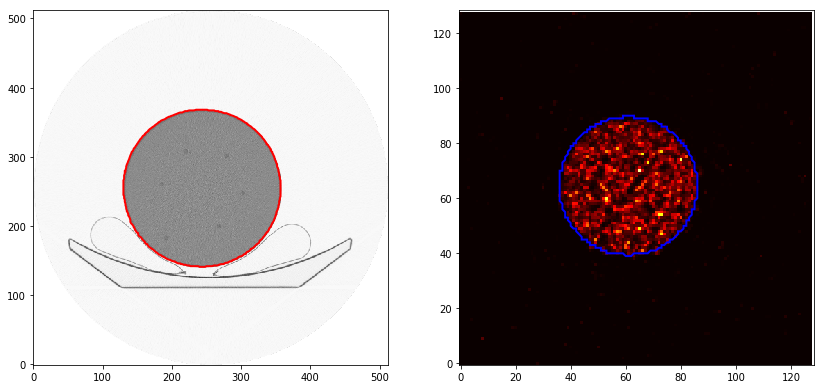

In [9]:
# 2D DISPLAY OF THE CONTOUR
# For display purposes, we need to switch from the image axes to the display axes


# Display and calculation Grid definition: (for CT and SPECT)
CTgrid_min = (0,0)
CTgrid_size = (CTsizeX, CTsizeY)
CTstep = (1,1)
CTvisFactor = 8
CTgrid_max = ((CTgrid_min[0]+CTgrid_size[0]*CTstep[0]), 
              (CTgrid_min[1]+CTgrid_size[1]*CTstep[1]))

SPECTgrid_min = (0,0)
SPECTgrid_size = (SPECTsizeX, SPECTsizeY)
SPECTstep = (1,1)
SPECTvisFactor = 8
SPECTgrid_max = ((SPECTgrid_min[0]+SPECTgrid_size[0]*SPECTstep[0]), 
                 (SPECTgrid_min[1]+SPECTgrid_size[1]*SPECTstep[1]))

CorrespondingSPECTSlice = int((SPECTzOrigin-CTzOrigin) / SPECTzSpacing)


# Matplotlib figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))

ax1.set_xlim(CTgrid_min[0]-0.5*CTstep[0], CTgrid_max[0]+0.5*CTstep[0])
ax1.set_ylim(CTgrid_min[1]-0.5*CTstep[1], CTgrid_max[1]+0.5*CTstep[1])

ax2.set_xlim(SPECTgrid_min[0]-0.5*SPECTstep[0], SPECTgrid_max[0]+0.5*SPECTstep[0])
ax2.set_ylim(SPECTgrid_min[1]-0.5*SPECTstep[1], SPECTgrid_max[1]+0.5*SPECTstep[1])


# Displays the background images
ax1.imshow(np.flip(CTpixArray, 0), cmap="Greys", interpolation="nearest", 
           vmin = -100, vmax = 2000)

ax2.imshow(np.flip(SPECTpixArray[CorrespondingSPECTSlice,:,:], 0), cmap="hot", interpolation="nearest", 
           vmin = 0, vmax = 300)


# Creation of the contour:
cc1 = coordConverter(CTxOrigin, CTyOrigin, CTxSpacing, CTySpacing, CTsizeX, CTsizeY)
CTdispPointList = cc1.converStructList(pointList)
CTpath_contour = matplotlib.path.Path(CTdispPointList)


# Creation of the contour:
cc2 = coordConverter(SPECTxOrigin, SPECTyOrigin, SPECTxSpacing, SPECTySpacing, SPECTsizeX, SPECTsizeY)
SPECTdispPointList = cc2.converStructList(pointList)
SPECTpath_contour = matplotlib.path.Path(SPECTdispPointList)


# Plots the contour
polygoneCT = plt.Polygon(CTdispPointList, fill=False, color = "red", linewidth=2)
ax1.add_patch(polygoneCT)

polygoneSPECT = plt.Polygon(SPECTdispPointList, fill=False, color = "blue", linewidth=2)
ax2.add_patch(polygoneSPECT)



rESULTS:
 -> Selected slice 80
 -> ROI volume: 166276.3802181449 mm3
 -> Total nb of counts: 82913
 -> Mean nb of counts: 43.00466804979253




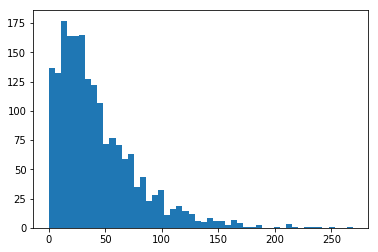



(execution time: 0.2249774932861328 s)


In [10]:
# NB OF COUNTS IN STRUCTURE CALCULATION (2D version):

# Calcul du temps d'execution:
time1 = time.time()

volPixel = SPECTxSpacing * SPECTySpacing * SPECTzSpacing
volROI = 0
nbCountsInROI = 0
nbPix = 0
pixValues = []
for i in range(SPECTsizeX):
    for j in range(SPECTsizeY):
        if SPECTpath_contour.contains_point((i,j)):
            volROI += volPixel
            nbCountsInROI += SPECTpixArray[CorrespondingSPECTSlice,j,i]
            pixValues.append(SPECTpixArray[CorrespondingSPECTSlice,j,i])
            nbPix += 1

time2 = time.time()

print('rESULTS:')
print(' -> Selected slice', CorrespondingSPECTSlice)
print(' -> ROI volume:', volROI, 'mm3')            
print(' -> Total nb of counts:', nbCountsInROI)
print(' -> Mean nb of counts:', nbCountsInROI/nbPix)
print('\n')

plt.hist(pixValues, 50)
plt.show()

print('\n\n(execution time:', time2-time1, 's)')


rESULTS:
 -> Selected ROI: 0
 -> ROI volume: 8109509.496015671 mm3
 -> Total nb of counts: 3410023
 -> Mean nb of counts in a pixel: 36.26488073082282




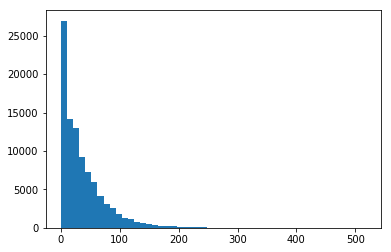



(execution time: 9.061420917510986 s)


In [11]:
# NB OF COUNTS IN STRUCTURE CALCULATION (3D version):


# Calcul du temps d'execution:
time1 = time.time()

# Variables initialization:
ROInb = 0
volPixel = SPECTxSpacing * SPECTySpacing * SPECTzSpacing
volROI = 0
nbCountsInROI = 0
nbPix = 0
pixValues = []

# Converter: contour point list in the SPECT coordinates
ccSPECT = coordConverter(SPECTxOrigin, SPECTyOrigin, SPECTxSpacing, SPECTySpacing, SPECTsizeX, SPECTsizeY)


# Gets the structure on first slice:
cd = struct.ROIContourSequence[ROInb].ContourSequence[0]

# Finds the corresponding z slice in the SPECT image:
imgID = cd.ContourImageSequence[0].ReferencedSOPInstanceUID
CTimg = dicom.read_file(m_path +'CT'+ imgID + '.dcm')
posz = int((SPECTzOrigin-CTimg.ImagePositionPatient[2]) / SPECTzSpacing)

# Gets the points list and converts it the pixel nb in SPECT img:
pl = getPointList(cd)
SPECTpath_contour = matplotlib.path.Path(cc2.converStructList(pl))

# Gets the statistics from the first slice:
for i in range(SPECTsizeX):
    for j in range(SPECTsizeY):
        if SPECTpath_contour.contains_point((i,j)):
            volROI += volPixel
            nbCountsInROI += SPECTpixArray[posz,j,i]
            pixValues.append(SPECTpixArray[posz,j,i])
            nbPix += 1


# Gets the statistics for the other slices:
nbslices = len(struct.ROIContourSequence[ROInb].ContourSequence)

for s in range(1, nbslices):
    cd = struct.ROIContourSequence[ROInb].ContourSequence[s]
    imgID = cd.ContourImageSequence[0].ReferencedSOPInstanceUID
    CTimg = dicom.read_file(m_path +'CT'+ imgID + '.dcm')
    z = int((SPECTzOrigin-CTimg.ImagePositionPatient[2]) / SPECTzSpacing)
    if z != posz:
        posz = z
        pl = getPointList(cd)
        SPECTpath_contour = matplotlib.path.Path(cc2.converStructList(pl))
        for i in range(SPECTsizeX):
            for j in range(SPECTsizeY):
                if SPECTpath_contour.contains_point((i,j)):
                    volROI += volPixel
                    nbCountsInROI += SPECTpixArray[posz,j,i]
                    pixValues.append(SPECTpixArray[posz,j,i])
                    nbPix += 1


time2 = time.time()
print('rESULTS:')
print(' -> Selected ROI:', ROInb)
print(' -> ROI volume:', volROI, 'mm3')            
print(' -> Total nb of counts:', nbCountsInROI)
print(' -> Mean nb of counts in a pixel:', nbCountsInROI/nbPix)
print('\n')

plt.hist(pixValues, 50)
plt.show()

print('\n\n(execution time:', time2-time1, 's)')


In [ ]:
N=0
pc=np.zeros((128,128,128))
for k in range (0,128):
    for i in range(0,128):
        for j in range(0,128):
             if mm[k,i,j]>0 :
                  pc[k,i,j]=p[k,i,j]
                  N=N+1
                    
v_f=(N*v_pixel) *10**(-3)                
print('le volume est de=',v_f  )                 
cp=np.sum(pc)
hour=int(img.AcquisitionTime[0:2])-14
min=int(img.AcquisitionTime[2:4])-59
t_s1=(23+hour)*60+min+10        #temps de comencent d'acqusition detecteur1  (min)
t_aq=int(img.RotationInformationSequence[0].ActualFrameDuration)*0.5/10**3         #duré d'acqusition (min)
t_p=792     #periode physique de 123-I (min)
#----------------------------------------------------------------------------------
A_inj_s1 =0.001093*16+(v_f+(-16))*0.000298   # l'activité de la suringue pliene (mCi)
t_s11=1       #temps de mesure  l'activité de la suringue pliene (min)
A_ss1=0   # l'activité de la suringue vide (mCi)
t_ss1=0       #temps de mesure  l'activité de la suringue vide (min)

A_ss1=(A_ss1 * exp((log(2)*t_ss1)/t_p))
A_inj_s1=(A_inj_s1 * exp((log(2)*t_s11)/t_p))
#correction de l'activité exact injecté  .
A_s1=A_inj_s1-A_ss1
#----------------------------------------------------------------------------------
#----------------------------------------------------------------------------------
A_inj_s2 =0.001093*8 +(v_f+(-8))*0.000298   # l'activité de la suringue pliene (mCi)
t_s2=1       #temps de mesure  l'activité de la suringue pliene (min)
A_ss2=0   # l'activité de la suringue vide (mCi)
t_ss2=0       #temps de mesure  l'activité de la suringue vide (min)

A_ss2=(A_ss2 * exp((log(2)*t_ss2)/t_p))
A_inj_s2=(A_inj_s2 * exp((log(2)*t_s2)/t_p))
#correction de l'activité exact injecté  .
A_s2=A_inj_s2-A_ss2
#----------------------------------------------------------------------------------
A_inj_fond =2.04   # l'activité de la suringue pliene (mCi)
t_fond=1      #temps de mesure  l'activité de la suringue pliene (min)
A_sfond=0  # l'activité de la suringue vide (mCi)
t_sfond=4      #temps de mesure  l'activité de la suringue vide (min)

A_sfond=(A_sfond * exp((log(2)*t_sfond)/t_p))
A_inj_fond=(A_inj_fond * exp((log(2)*t_fond)/t_p))
#correction de l'activité exact injecté  .
A_fond=A_inj_fond-A_sfond
#----------------------------------------------------------------------------------


#----------------------------------------------------------------------------------






#A_total=A_pd+A_lf+A_lc+A_foie+A_fond+A_pg
A_total=A_fond
# l'activité au moment de commencement d'acquisition  .

# l'activité au moment de commencement d'acquisition  .
A_01=A_total * exp((-log(2)*t_s1)/t_p)


# l'activité moyenne entre le debut et la fin d'acquisition mCi .


# nombre de coups par seconde    
cps=cp/(t_aq*2*60)
# l'activité moyenne entre le debut et la fin d'acquisition (MBq)  .
A_m1=(A_01 *37*(t_p/log(2))* (1-exp(-log(2)*t_aq/t_p)))/t_aq

A_mesuré=cps/62.5
print('activité réelle =',A_m1)
print('activité mesuré',A_mesuré)
v=abs(A_mesuré-A_m1)*100/A_m1
print('variation relative',v,'%')